# Moving Average model

## O que são?

Modelos de média móvel são modelos que utilizam os erros das previsões passadas para ajustar uma previsão futura.

Um modelo de média móvel de ordem 1 pode ser descrito da seguinte maneira:

__MA(1)__ -> $\hat{y}_t = \mu + \phi_1 * \epsilon_{t-1}$

Onde $\hat{y}_t$ é o valor predito no instante _t_ , $\mu$ é um valor médio constante, $\phi_1$ é o peso do erro no tempo _t-1_ e $\epsilon_{t-1}$ é o erro no tempo _t-1_.

Sendo assim o valor de __y__ será o valor previsto + o erro entre o valor real e o previsto: $y = \hat{y} + \epsilon_t$

Para um modelo de ordem _q_ temos que:
__MA(q)__ -> $\hat{y}_t = \mu + \phi_1 * \epsilon_{t-1} + \phi_2 * \epsilon_{t-2} + ... + \phi_q * \epsilon_{t-q}$

Recomendado para séries que não apresentam tendências ou sazonalidade

## Exemplo: 


Considerando o dataset de passageiros mensais em um avião e MA(1):

Supondo que $\mu = 100$ seja o valor médio de passageiros (atribuído aleatóriamente) e $\phi = 0.5$ para todos os casos

$\hat{y}_1 = 100 + \phi * \epsilon_0 = 100$ pois não há erros para $\epsilon_0$

Para o mês 1  $y = 112$ então tivemos um erro de 12 passageiros

$\hat{y}_2 = 100 + \phi * \epsilon_1 = 100 + 0.5 * 12 = 106$  -- $y = 118$ então  -- $\epsilon_2 = 12$

$\hat{y}_3 = 100 + \phi * \epsilon_2 = 100 + 0.5 * 12 = 106$  -- $y = 132$ então  -- $\epsilon_3 = 26$

$\hat{y}_4 = 100 + \phi * \epsilon_3 = 100 + 0.5 * 26 = 113$  -- $y = 129$ então  -- $\epsilon_4 = 16$

$\hat{y}_5 = 100 + \phi * \epsilon_4 = 100 + 0.5 * 8 = 104$  -- $y = 121$ então  -- $\epsilon_5 = 17$

## Exemplo prático

In [56]:
#Importando bibliotecas básicas

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pylab
from datetime import datetime

%matplotlib inline

In [146]:
# Lendo arquivo CSV contendo data e número de passageiros no vôo
df = pd.read_csv('Datasets/AirPassengers.csv')

#Definindo as datas como índice
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')
df = df.rename(columns={"#Passengers":"Passengers"})
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Autocorrelação

Um aspecto muito importante ao analisar a auto correlação é que, o modelo AR é aplicado em dados que apresentem uma queda gradual na autocorrelação (como é o caso deste dataset), enquanto o modelo MA é aplicado em dados cuja autocorrelação tem uma queda brusca a partir de um ponto _q_ .

Este dataset apresenta queda gradual na autocorrelação, então o ideal é utilizar o modelo AR, porém, para fins comparativos utilizarei o modelo MA

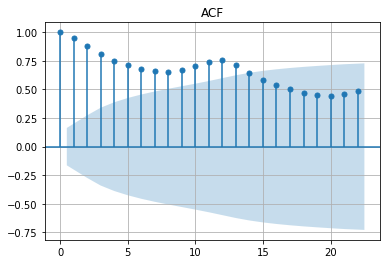

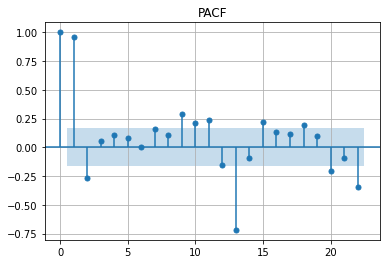

In [147]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plotando função de autocorrelação
plot_acf(df, title = 'ACF')
plt.grid()

#Plotando função de autocorrelação parcial
plot_pacf(df, title = 'PACF')
plt.grid()

plt.show()

### Dividindo dados de treino e teste

In [148]:
def test_train (data):
    train_len = int(len(data)*0.75)
    train = data[0:train_len]
    test = data[train_len:]
    return train, test

train, test = test_train(df)

### Criando modelo MA

Para criar um modelo moving average é necessário utilizar a função ARMA (Autoregressive Moving Average)

O método ARMA combina os métodos AR e MA, que são definidos através do parâmetro order = (_p_,_q_), onde _p_ é o parâmetro para __AR(_p_)__ e _q_ é o parâmetro para __MA(_q_)__. Para obter apenas MA(_q_) deve-se definir _p_=0

In [164]:
# MA example
from statsmodels.tsa.arima_model import ARMA

ma_model = ARMA(endog = train, order=(1, 3), freq = 'MS')

ma_fit = ma_model.fit()

# make prediction
predictions = ma_fit.predict(start=datetime(1949, 1, 1), end=datetime(1958, 6, 1))

C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\mpere\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inver

### Criando dataset para armazenar os resultados

In [165]:
df_res = pd.DataFrame()
df_res['Real'] = train['Passengers']
df_res['Predicted'] = predictions

df_res = df_res[1:]

df_res.head()

,Real,Predicted
1949-02-01,118,112.087485
1949-03-01,132,119.028778
1949-04-01,129,132.465540
1949-05-01,121,122.037965
1949-06-01,135,120.730967


### Avaliando o erro RMSE

In [166]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def get_rmse (real, predicted):
    rmse = sqrt(mean_squared_error(real, predicted))
    print('Test RMSE: %.3f' % rmse)
    
get_rmse(df_res['Real'], df_res['Predicted'])

Test RMSE: 23.485


### Plotando resultado

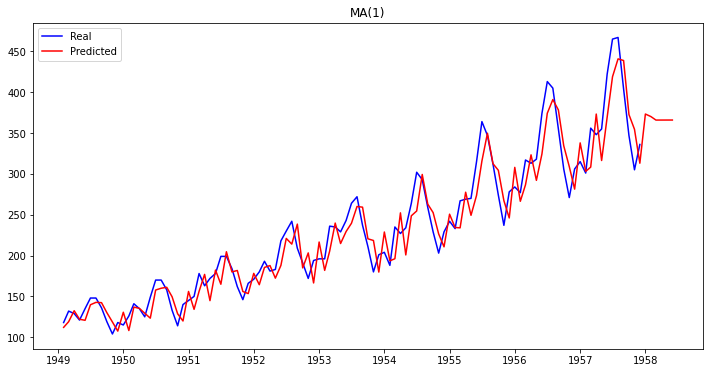

In [187]:
plt.figure(figsize=(12,6))

plt.plot(df_res.index, df_res['Real'], color='blue')
plt.plot(predictions[1:].index, predictions[1:], color = 'red')

plt.title('MA(1)')
plt.legend(['Real', 'Predicted'])

plt.show()

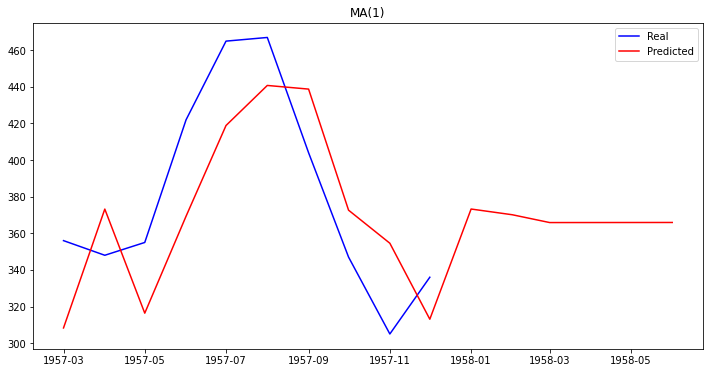

In [186]:
plt.figure(figsize=(12,6))

plt.plot(df_res.index[-10:], df_res['Real'][-10:], color='blue')
plt.plot(predictions[-16:].index, predictions[-16:], color = 'red')

plt.title('MA(1)')
plt.legend(['Real', 'Predicted'])

plt.show()

### Conclusão

O modelo MA necessita de um número de janelas para obter valor $y_t$

Foi possível prever o próximo valor de $y_t$, porém a partir de duas previsões, estas começam a seguir um único valor